In [88]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import dataframe_image as dfi
import seaborn as sns

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
dir_path = "C:\\Users\\davidsong\\Desktop\\USAID\\Documents\\Data\\"
file_name = "Financial_Structured_Datasets_COP17-21_20211217.txt"
df_fsd = pd.read_csv(dir_path+file_name,
           sep = '\t')

In [3]:
df_fsd = df_fsd.rename(columns={'workplan_budget_amt': 'workplan',
                               'expenditure_amt': 'expenditure',
                               'cop_budget_total': "cop"})

In [4]:
cols = ['operatingunit', 'country','mech_code', 'mech_name',
       'program', 'sub_program', 'interaction_type',
       'beneficiary', 'sub_beneficiary', 'cost_category', 'sub_cost_category',
       'planning_cycle', 'implementation_year', 'cop', 'workplan',
       'expenditure']

In [5]:
# Confirming expenditures reported  for COP20, FY21
cond_yr20 = df_fsd['planning_cycle'] == 'COP20'
print(df_fsd[cond_yr20].shape[0])
print(sum(df_fsd[cond_yr20]['expenditure'].isna()))

62177
16449


In [6]:
# workplan also already reported  for COP20, FY21
cond_yr20 = df_fsd['planning_cycle'] == 'COP21'
print(df_fsd[cond_yr20].shape[0])
print(sum(df_fsd[cond_yr20]['workplan'].isna()))

36588
8081


In [7]:
cond_19 = df_fsd['planning_cycle'] == 'COP20'
cond_21 = df_fsd['planning_cycle'] == 'COP21'
# cond_agency = df_fsd['fundingagency'] == 'USAID'

# df_subset_exp = df_fsd[cond_19 & cond_agency][cols]
# df_subset_work = df_fsd[cond_21 & cond_agency][cols]
df_subset_exp = df_fsd[cond_19][cols]
df_subset_work = df_fsd[cond_21][cols]

In [8]:
def add_perc_rank(df, col):
    col_sum = sum(df[col])
    df['percent'] = df[col] / col_sum
    df['rank'] = df[col].rank(ascending=False)
    
def count_df(df, count_col, groupby_cols = ['program', 'beneficiary']):    
    df_count = df.groupby(by = groupby_cols).count()[[count_col]]
    df_count = df_count.sort_values(by=count_col, ascending=False)
    add_perc_rank(df_count, count_col)
    
    return df_count

def sum_df(df, sum_col, groupby_cols=['program', 'beneficiary']):
    df_sum = df.groupby(by = groupby_cols).sum()[[sum_col]]
    df_sum = df_sum.sort_values(by=sum_col, ascending=False)
    add_perc_rank(df_sum, sum_col)
    
    return df_sum

def highlight_diff(column, diff=5):
    highlight = 'background-color: yellow;'
    default = ''
    return [highlight if abs(v) > diff else default for v in column]

def pipeline_compare(df1, df2):
    df_merge = df1.merge(df2, how='outer', left_index=True, right_index=True)
    df_merge=df_merge.sort_values(by='rank_x')
    df_merge['rank_diff'] = df_merge['rank_x'] - df_merge['rank_y']
    return df_merge

In [9]:
# drop any rows that have no expenditure for our desired Fiscal Year
cond_has_exp = df_subset_exp["expenditure"] > 0
df_subset_exp = df_subset_exp[cond_has_exp]

cond_has_workplan = df_subset_work["workplan"] > 0
df_subset_work = df_subset_work[cond_has_workplan]

In [10]:
df_subset_exp = df_subset_exp.replace({'sub_program':{"Comm. mobilization, behavior & norms change": "Comm. mobilization",
                               "Policy, planning, coordination & management of disease control programs": "Policy, planning...",
                               "Primary prevention of HIV and sexual violence": "Prevent HIV & sexual violence"},
                'beneficiary':{"Pregnant & Breastfeeding Women" : "PBFW"},
                'sub_beneficiary':{"Young women & adolescent females": "AGYW",
                                   "Orphans & vulnerable children": "OVC",
                                   "Military & other uniformed services": "Military...",
                                   "Young people & adolescents": "Young people..."
                                  }
               })

df_subset_work = df_subset_work.replace({'sub_program':{"Comm. mobilization, behavior & norms change": "Comm. mobilization",
                               "Policy, planning, coordination & management of disease control programs": "Policy, planning...",
                               "Primary prevention of HIV and sexual violence": "Prevent HIV & sexual violence"},
                'beneficiary':{"Pregnant & Breastfeeding Women" : "PBFW"},
                'sub_beneficiary':{"Young women & adolescent females": "AGYW",
                                   "Orphans & vulnerable children": "OVC",
                                   "Military & other uniformed services": "Military...",
                                   "Young people & adolescents": "Young people..."
                                  }
               })

In [11]:
pb_count_exp = count_df(df_subset_exp, "expenditure")
pb_count_work = count_df(df_subset_work, "workplan")
df_pb_count = pipeline_compare(pb_count_exp, pb_count_work)
pb_count_styled = df_pb_count.style.apply(highlight_diff, subset=['rank_diff'], axis=0)
pb_count_styled

In [12]:
#dfi.export(pb_count_styled, "pb_count.png")

In [13]:
# Only 37 out of 42 possible program-beneficiary combinations are observed in COP19 Expenditure
# and only 38 out of 42 for COP21 Workplan. 40 if you overlap them
df_pb_count.shape[0]

40

In [14]:
def find_idx_over_90(df, threshold=0.9, col='percent_x'):
    idx_over_90 = 0
    len_df = df.shape[0]
    for i in range(len_df):
        if df.head(i)[col].sum() > threshold:
            idx_over_90 = i
            break
    # add +1 to idx_over_90 to include the 0th position in the percentage
    return({'idx': idx_over_90, 'perc': (idx_over_90+1)/len_df})

In [107]:
count_exp_out = pb_count_exp.copy()
count_exp_out = count_exp_out.rename(columns={"expenditure":"count in expenditure reporting"})
count_exp_out["percent"] = count_exp_out["percent"]*100
count_exp_out_styled = count_exp_out.style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%", 
                               subset=pd.IndexSlice[:, ["percent"]])\
                                .set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

dfi.export(count_exp_out_styled, "pb_count.png")

In [15]:
pb_uniq_dict = find_idx_over_90(df_pb_count)
print(pb_uniq_dict)
print(pb_uniq_dict['idx']/42)

{'idx': 17, 'perc': 0.45}
0.40476190476190477


In [16]:
pb_uniq_dict = find_idx_over_90(df_pb_count, 0.5)
print(pb_uniq_dict)
print(pb_uniq_dict['idx']/42)

{'idx': 5, 'perc': 0.15}
0.11904761904761904


In [17]:
cond_cop_na = df_subset_exp['cop'].isna()
df_cop_non_null = df_subset_exp[~cond_cop_na]

print(df_cop_non_null.shape)

sum(df_cop_non_null['expenditure'].isna())

(0, 16)


0

#### Conclusions on above:
Weirdly, COP and expenditures appear to always be on separate rows in COP19

In [18]:
sub_interv_grp = ['program', 'sub_program', 'beneficiary', 'sub_beneficiary']

sub_count_exp = count_df(df_subset_exp, "expenditure", sub_interv_grp)
sub_count_work = count_df(df_subset_work, "workplan", sub_interv_grp)
df_sub_count = pipeline_compare(sub_count_exp, sub_count_work)
sub_count_style = df_sub_count.head(50).style.apply(highlight_diff, subset=['rank_diff'], axis=0)
sub_count_style

In [19]:
dfi.export(sub_count_style, "sub_count.png")

In [20]:
# There are 27 sub-beneficiaries and 54 sub-program areas, meaning 1458 possible combinations.
# However, only 295 are used in COP19
true_total_subpb = 27*54
print(true_total_subpb)
print(df_sub_count.shape[0])
print(df_sub_count.shape[0]/true_total_subpb)

1458
363
0.24897119341563786


In [21]:
# https://datim.zendesk.com/hc/en-us/articles/360015671212-PEPFAR-Financial-Classifications-Reference-Guide
# Looking at the actual financial framework, there is only 34 sub-program areas if we merge service and non-service delivery
# So, the true total should be 34*27

true_total_sub_pb = 34*27

In [22]:
true_total_sub_pb

918

In [23]:
# 5.5% of sub-interventions make up 50% of all reported items
sub_pb_dict = find_idx_over_90(df_sub_count, 0.5)
print(sub_pb_dict)
sub_pb_dict['idx']/true_total_subpb

{'idx': 19, 'perc': 0.05509641873278237}


0.013031550068587106

In [24]:
sub_pb_dict = find_idx_over_90(df_sub_count, 0.9)
print(sub_pb_dict)
sub_pb_dict['idx']/true_total_subpb

{'idx': 100, 'perc': 0.27823691460055094}


0.06858710562414266

# Sum of total expenditure per intervention
Instead of unique rows, use actual sum of expenditure

In [25]:
pb_sum_exp = sum_df(df_subset_exp, "expenditure")
pb_sum_work = sum_df(df_subset_work, "workplan")
df_pb_sum = pipeline_compare(pb_sum_exp, pb_sum_work)
pb_sum_style = df_pb_sum.style.apply(highlight_diff, subset=['rank_diff'], axis=0)
pb_sum_style

In [26]:
dfi.export(pb_sum_style, "pb_sum.png")

In [99]:
sum_exp_out = pb_sum_exp.head(17).copy()
sum_exp_out = sum_exp_out.rename(columns={"expenditure":"total expenditure"})
sum_exp_out["percent"] = sum_exp_out["percent"]*100
sum_exp_out.style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%", 
                           subset=pd.IndexSlice[:, ["percent"]])\
                 .format(na_rep='', precision=2, thousands=",",formatter="${:,.0f}",
                        subset=pd.IndexSlice[:,['total expenditure']])\
                    .set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

In [27]:
pb_sum_dict = find_idx_over_90(df_pb_sum, 0.5)
print(pb_sum_dict)
pb_sum_dict['idx']/42

{'idx': 2, 'perc': 0.075}


0.047619047619047616

In [28]:
pb_sum_dict = find_idx_over_90(df_pb_sum, 0.9)
print(pb_sum_dict)
pb_sum_dict['idx']/42

{'idx': 11, 'perc': 0.3}


0.2619047619047619

In [29]:
sub_interv_grp = ['program', 'sub_program', 'beneficiary', 'sub_beneficiary']

sub_sum_exp = sum_df(df_subset_exp, "expenditure", sub_interv_grp)
sub_sum_work = sum_df(df_subset_work, "workplan", sub_interv_grp)
df_sub_sum = pipeline_compare(sub_sum_exp, sub_sum_work)
sub_sum_style = df_sub_sum.head(50).style.apply(highlight_diff, subset=['rank_diff'], axis=0)
sub_sum_style

In [30]:
dfi.export(sub_sum_style, "sub_sum.png")

In [31]:
subpb_sum_dict = find_idx_over_90(df_sub_sum, 0.5)
print(subpb_sum_dict)
subpb_sum_dict['idx']/true_total_subpb

{'idx': 4, 'perc': 0.013774104683195593}


0.0027434842249657062

In [32]:
subpb_sum_dict = find_idx_over_90(df_sub_sum, 0.9)
print(subpb_sum_dict)
subpb_sum_dict['idx']/true_total_subpb

{'idx': 51, 'perc': 0.14325068870523416}


0.03497942386831276

In [33]:
df_sub_sum['expenditure'].head(95).sum()

3961962830.0

# Heatmaps of expenditure

In [34]:
df_sub_count.shape

(363, 7)

In [35]:
def make_heat(df):
    df_heat = pd.pivot_table(df[["expenditure"]].reset_index(),
                                index = ['program', 'sub_program'],
                                columns = ['beneficiary', 'sub_beneficiary'],
                                values = 'expenditure'
                               )
    # Add missing sub-program row
    df_heat.loc[("ASP", "Injection safety"),] = np.nan
    
    # Sort beneficiaries
    sum_ben = df_heat.sum(axis=0, skipna=True)
    sum_ben = sum_ben.rename(('sum', 'beneficiaries'))
    df_heat = df_heat.append(sum_ben).sort_values(by=('sum', 'beneficiaries'), axis=1, ascending=False)
    df_heat.drop(('sum', 'beneficiaries'), inplace=True)
    
    # Sort programs
    sum_prog = df_heat.sum(axis=1, skipna=True)
    sum_prog = sum_prog.rename(('sum', 'prog'))
    df_heat[('sum', 'prog')] = sum_prog
    df_heat = df_heat.sort_values(by=('sum', 'prog'), ascending=False)
    df_heat.drop(columns=('sum', 'prog'), inplace=True)
    
    return df_heat

In [36]:
colors.Normalize(0,5)

In [37]:
#m = heat_sub_count.min().min()
#M = heat_sub_count.max().max()
#rng = M - m
#norm = colors.Normalize(m - (rng * 0),
#                            M + (rng * 0.2))
#norm(heat_sub_count.values)

In [38]:
# https://stackoverflow.com/questions/38931566/pandas-style-background-gradient-both-rows-and-columns/42563850#42563850
# style.background_gradient only works on columns or rows, not both, so use custom function
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [39]:
# https://stackoverflow.com/questions/38931566/pandas-style-background-gradient-both-rows-and-columns/42563850#42563850
# style.background_gradient only works on columns or rows, not both, so use custom function
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    font_c = [colors.rgb2hex(x) for x in plt.cm.get_cmap('binary')(normed)]
    return ['background-color: %s; color: %s' % (color, fnt) for (color, fnt) in zip(c, font_c)]

In [40]:
# convert counts to percent of total, for easier comparison
df_sub_count_perc = df_sub_count.copy()
df_sub_count_perc["expenditure"] = (df_sub_count_perc["expenditure"] / df_sub_count['expenditure'].sum())*100

In [41]:
1/(34*27)

0.0010893246187363835

In [42]:
np.nan >0.1

False

In [43]:
def custom_gradient(val):
    if val < 0.1:
        color = "dimgray"
        if val < 0.05:
            color= "darkgray"
        return 'background-color: %s' % color
    if pd.isna(val):
        return 'background-color: lightgrey'

In [44]:
heat_sub_count = make_heat(df_sub_count_perc)
heat_count_style = heat_sub_count.style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%")\
                .apply(background_gradient,
                        cmap='viridis',
                        m = heat_sub_count.min().min(),
                        M = 2, #heat_sub_count.max().max(),
                        low=0.001,
                        high=0.8)\
                .applymap(custom_gradient)\
                .set_table_styles([{'selector': 'td', 'props':'border: 1px solid white'}])
heat_count_style

In [45]:
dfi.export(heat_count_style, "heat_sub_count.png")
heat_count_style.to_excel("heat_sub_count.xlsx", engine="openpyxl")

In [46]:
# convert counts to percent of total, for easier comparison
df_sub_sum_perc = df_sub_sum.copy()
df_sub_sum_perc["expenditure"] = (df_sub_sum_perc["expenditure"] / df_sub_sum['expenditure'].sum())*100

In [47]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
heat_sub_sum = make_heat(df_sub_sum_perc)
heat_sum_style = heat_sub_sum.style.format(na_rep='NA', precision=2, thousands=",",formatter = "{:,.2f}%")\
                .applymap(lambda x: 'color: grey')\
                .apply(background_gradient,
                        cmap='viridis',
                        m = heat_sub_sum.min().min(),
                        M = 2,
                        low=0,
                        high=0.8)\
                .applymap(custom_gradient)\
                .set_table_styles([{'selector': 'td', 'props':'border: 1px solid grey'}])
heat_sum_style

In [48]:
# dfi.export(heat_sum_style, "heat_sub_sum.png")
# heat_sum_style.to_excel("heat_sub_sum.xlsx", engine="openpyxl")

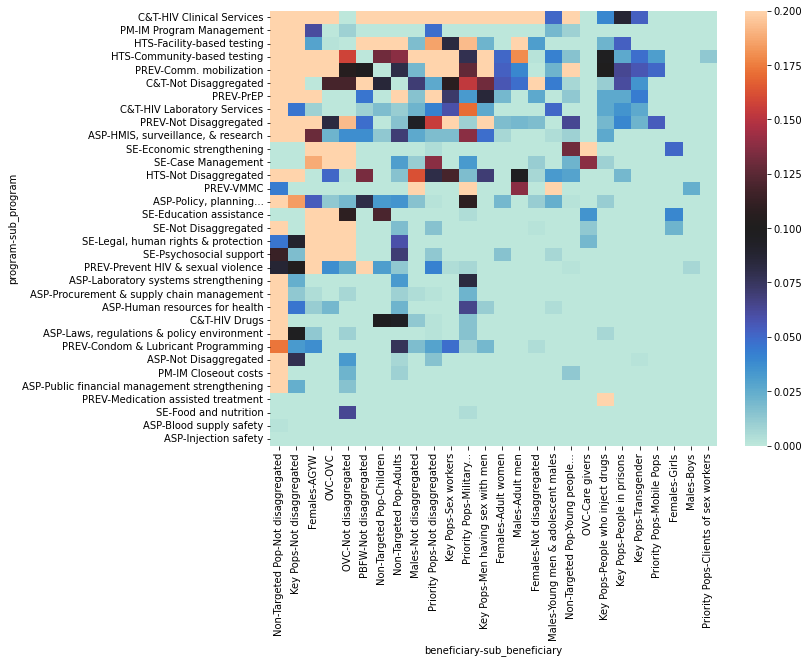

In [49]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(heat_sub_count.fillna(0), vmax=0.2, center=0.1)

plt.savefig('heat_sub_count_stylized.png', bbox_inches='tight')

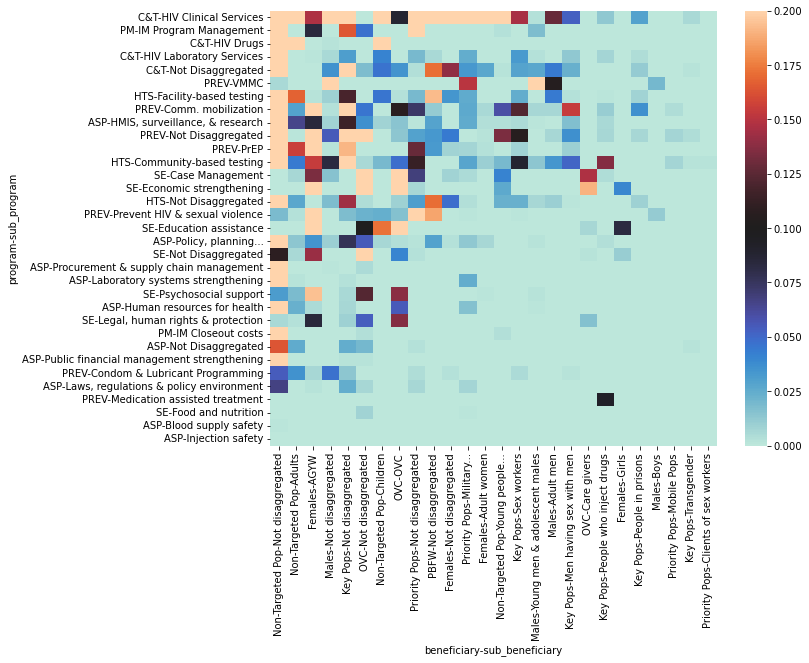

In [50]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(heat_sub_sum.fillna(0), vmax=0.2, center=0.1)
plt.savefig('heat_sub_sum_stylized.png', bbox_inches='tight')

In [51]:
# Only 1 sub-program area is never useda
missing_prog = ("ASP", "Injection safety")

In [52]:
# df_sub_count.reset_index().groupby(['beneficiary','sub_beneficiary']).sum()[['expenditure']]

# Beneficiary splits

In [120]:
benef_count =  pb_count_exp.groupby(by='beneficiary').sum()[["expenditure"]].sort_values(by="expenditure", 
                                                                                         ascending=False)

add_perc_rank(benef_count, "expenditure")
benef_count = benef_count.rename(columns={"expenditure":"count in FSD"})
benef_count['percent'] = benef_count['percent']*100

benef_count.style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%", 
                           subset=pd.IndexSlice[:, ["percent"]])\
                    .set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

,count in FSD,percent,rank
beneficiary,,,
Non-Targeted Pop,23804,52.06%,1.000000
Key Pops,5752,12.58%,2.000000
OVC,5083,11.12%,3.000000
Females,4684,10.24%,4.000000
Males,2288,5.00%,5.000000
PBFW,2246,4.91%,6.000000
Priority Pops,1871,4.09%,7.000000


In [54]:
1/27

0.037037037037037035

In [122]:
sub_ben_count = sub_count_exp.groupby(by=['beneficiary', 'sub_beneficiary']).sum()[['expenditure']].sort_values(by='expenditure',
                                                                                                               ascending=False)
add_perc_rank(sub_ben_count, "expenditure")

sub_ben_count = sub_ben_count.rename(columns={"expenditure":"count in FSD"})
sub_ben_count['percent'] = sub_ben_count['percent']*100
sub_ben_count.style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%", 
                           subset=pd.IndexSlice[:, ["percent"]])\
                    .set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

In [56]:
sub_ben_count = sub_count_exp.groupby(by=['sub_beneficiary']).sum()[['expenditure']].sort_values(by='expenditure',
                                                                                                               ascending=False)
add_perc_rank(sub_ben_count, "expenditure")
sub_ben_count.loc[["Not disaggregated",]]

,expenditure,percent,rank
sub_beneficiary,,,
Not disaggregated,31543,0.6898,1.0000


# By Program Area

In [123]:
pa_count =  pb_count_exp.groupby(by='program').sum()[["expenditure"]].sort_values(by="expenditure", 
                                                                                         ascending=False)

add_perc_rank(pa_count, "expenditure")

pa_count = pa_count.rename(columns={"expenditure":"count in FSD"})
pa_count['percent'] = pa_count['percent']*100

pa_count.style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%", 
                           subset=pd.IndexSlice[:, ["percent"]])\
                    .set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

,count in FSD,percent,rank
program,,,
C&T,13909,30.42%,1.000000
PREV,8852,19.36%,2.000000
HTS,7568,16.55%,3.000000
SE,6156,13.46%,4.000000
PM,4640,10.15%,5.000000
ASP,4603,10.07%,6.000000


In [112]:
sub_pa_count.shape

(32, 3)

In [124]:
sub_pa_count = sub_count_exp.groupby(by=['program', 'sub_program']).sum()[['expenditure']].sort_values(by='expenditure',
                                                                                                               ascending=False)
add_perc_rank(sub_pa_count, "expenditure")

sub_pa_count = sub_pa_count.rename(columns={"expenditure":"count in FSD"})
sub_pa_count['percent'] = sub_pa_count['percent']*100

sub_pa_count.head(17).style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%", 
                           subset=pd.IndexSlice[:, ["percent"]])\
                    .set_table_styles([dict(selector="th",props=[('max-width', '150px')])])

In [125]:
sub_pa_count.tail(15).style.format(na_rep='', precision=2, thousands=",",formatter = "{:,.2f}%", 
                           subset=pd.IndexSlice[:, ["percent"]])\
                    .set_table_styles([dict(selector="th",props=[('max-width', '150px')])])

In [59]:
sub_pa_count = sub_count_exp.groupby(by=['sub_program']).sum()[['expenditure']].sort_values(by='expenditure',
                                                                                                               ascending=False)
add_perc_rank(sub_pa_count, "expenditure")

sub_pa_count.loc[["Not Disaggregated",]]

,expenditure,percent,rank
sub_program,,,
Not Disaggregated,6573,0.1437,2.0000


In [60]:
# One-third of sub-program labels are used less than 1% of the time
sum(sub_pa_count["percent"]<0.01)/len(sub_pa_count)

0.32142857142857145

In [118]:
sum(sub_pa_count["percent"]<0.01)

10

In [61]:
len(sub_pa_count)

28

# Comparing Mechanisms by usage of non-disaggregate vs. # unique interventions

In [62]:
def count_df(df, count_col, groupby_cols = ['program', 'beneficiary']):
    df_count = df.groupby(by = groupby_cols).count()[[count_col]]
    df_count = df_count.sort_values(by=count_col, ascending=False)
    add_perc_rank(df_count, count_col)
    
    return df_count

In [126]:
df_exp_mech = df_subset_exp.copy()
df_exp_mech["program_sub"] = df_exp_mech["program"] + " - " + df_exp_mech["sub_program"]
df_exp_mech["beneficiary_sub"] = df_exp_mech["beneficiary"] + " - " + df_exp_mech["sub_beneficiary"]
df_exp_mech["sub_intervention"] = df_exp_mech["program_sub"] + " - " + "beneficiary_sub"

In [127]:
df_subset_exp.head()

,operatingunit,country,mech_code,mech_name,program,sub_program,interaction_type,beneficiary,sub_beneficiary,cost_category,sub_cost_category,planning_cycle,implementation_year,cop,workplan,expenditure
36595,Angola,Angola,80060,AFENET,ASP,Laboratory systems strengthening,Non Service Delivery,Non-Targeted Pop,Not disaggregated,Personnel,Salaries- Other Staff,COP20,2021,NaN,67192.00,360796.00
36601,Angola,Angola,80060,AFENET,ASP,Laboratory systems strengthening,Non Service Delivery,Non-Targeted Pop,Not disaggregated,Supplies,Other Supplies,COP20,2021,NaN,33188.00,30230.00
36602,Angola,Angola,80060,AFENET,C&T,HIV Laboratory Services,Non Service Delivery,Non-Targeted Pop,Not disaggregated,Travel,Domestic Travel,COP20,2021,NaN,86400.00,38927.00
36604,Angola,Angola,80060,AFENET,C&T,HIV Laboratory Services,Non Service Delivery,Non-Targeted Pop,Not disaggregated,Supplies,Other Supplies,COP20,2021,NaN,20773.00,122536.00
36607,Angola,Angola,80060,AFENET,C&T,HIV Laboratory Services,Non Service Delivery,Non-Targeted Pop,Not disaggregated,Contractual,Other Contracts,COP20,2021,NaN,NaN,75412.00


In [131]:
mech_uniques = df_exp_mech.groupby(by=["mech_name", "mech_code"]).nunique()[["program_sub", "beneficiary_sub", "sub_intervention"]]

In [132]:
mech_uniques.shape

(943, 3)

In [133]:
mech_uniques.head()

,,program_sub,beneficiary_sub,sub_intervention
mech_name,mech_code,,,
"(DIGECITSS) Improving PMTCT counseling, M&E of the PMTCT program, STI services and surveillance, establish performance management of HIV treatment, and capacity of the National Program to address strategic issues for Key Populations",17527,4,2,4
"(MOH) Strengthening M&E, FETP capacity, health information systems (HIV, TB, laboratory data, and disease surveillance), Supply of safe blood, and national laboratory improvement plan in the DR MoH",17561,2,1,2
4Children – Coordinating Comprehensive Care for Children,18143,5,1,5
"70018 HIV Prevention, Care and Treatment for the Burundi National Defense Forces",70018,8,2,8
82194 Liberia DOD,82194,8,3,8


In [134]:
df_exp_mech["disagg_program"] = df_exp_mech["sub_program"] == 'Not Disaggregated'

In [135]:
df_exp_mech["disagg_benef"] = df_exp_mech["sub_beneficiary"] == "Not disaggregated"

In [136]:
mech_disagg_count = df_exp_mech.groupby(by=["mech_name", "mech_code"]).sum()[["disagg_program", "disagg_benef"]]

In [137]:
mech_disagg_count.head()

,,disagg_program,disagg_benef
mech_name,mech_code,,
"(DIGECITSS) Improving PMTCT counseling, M&E of the PMTCT program, STI services and surveillance, establish performance management of HIV treatment, and capacity of the National Program to address strategic issues for Key Populations",17527,0,5
"(MOH) Strengthening M&E, FETP capacity, health information systems (HIV, TB, laboratory data, and disease surveillance), Supply of safe blood, and national laboratory improvement plan in the DR MoH",17561,0,5
4Children – Coordinating Comprehensive Care for Children,18143,0,59
"70018 HIV Prevention, Care and Treatment for the Burundi National Defense Forces",70018,0,19
82194 Liberia DOD,82194,5,8


In [138]:
df_subset_exp.shape

(45728, 16)

In [139]:
merge_mech = mech_uniques.merge(mech_disagg_count, left_index=True, right_index=True)

In [140]:
merge_mech["total_unique"] = merge_mech["program_sub"] + merge_mech["beneficiary_sub"]
merge_mech["total_disagg"] = merge_mech["disagg_program"] + merge_mech["disagg_benef"]

In [141]:
cond_prog_outlier = merge_mech['disagg_program']<150
cond_benef_outlier = merge_mech['disagg_benef']<500

mech_no_outlier = merge_mech[cond_prog_outlier & cond_benef_outlier]

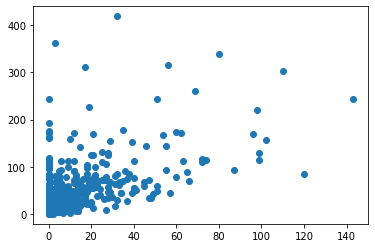

In [142]:
plt.scatter(mech_no_outlier['disagg_program'], mech_no_outlier['disagg_benef'])

In [77]:
# https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

Text(0, 0.5, "Total # of 'Not Disaggregated'")

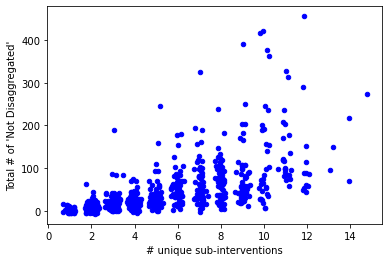

In [145]:
jitter(mech_no_outlier['sub_intervention'], mech_no_outlier['total_disagg'])
plt.xlabel("# unique sub-interventions")
plt.ylabel("Total # of 'Not Disaggregated'")

Text(0, 0.5, "Total # of 'Not Disaggregated' in sub-programs")

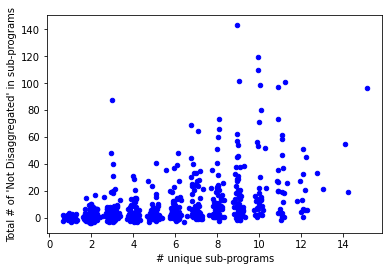

In [146]:
jitter(mech_no_outlier['program_sub'], mech_no_outlier['disagg_program'])
plt.xlabel("# unique sub-programs")
plt.ylabel("Total # of 'Not Disaggregated' in sub-programs")

Text(0, 0.5, "Total # of 'Not Disaggregated' in sub-beneficiaries")

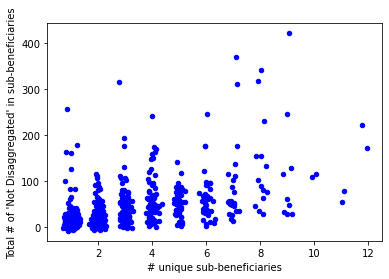

In [147]:
jitter(mech_no_outlier['beneficiary_sub'], mech_no_outlier['disagg_benef'])
plt.xlabel("# unique sub-beneficiaries")
plt.ylabel("Total # of 'Not Disaggregated' in sub-beneficiaries")